# Global Setting

In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import acovf
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from pmdarima.arima import auto_arima
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

##### Load data

In [80]:
sales = pd.read_csv('../data/sales_products_ts.csv')
products_info = pd.read_csv("../data/products_statistics.csv")

Define error functions

In [25]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def wape(y_true, y_pred):
    acovf_vals = acovf(y_true, unbiased=False)
    return np.sum(np.abs(y_true - y_pred) / acovf_vals) * 100

# metric for interminent demand series
mase = MeanAbsoluteScaledError()



Define metrics dataframe

In [87]:
metrics = pd.DataFrame(columns=['id','model','rmse', 'mape', 'mase'])

Replace outliers function

In [88]:
def replace_outliers(df):
    q3 = np.quantile(df['quantity'], 0.75)
    q1 = np.quantile(df['quantity'], 0.25)
    iqr = np.subtract(*np.percentile(df['quantity'], [75, 25], interpolation='linear', axis=0))
    max_limit = q3 + (1.5 * iqr)
    min_limit = q1 - (1.5 * iqr)
    df.loc[df['quantity'] > max_limit, 'quantity'] = max_limit
    df.loc[df['quantity'] < min_limit, 'quantity'] = min_limit

    return df


Preprocessing data

In [78]:
def preprocessing(df):
    sorted = df.groupby('id').sum('quantity').sort_values('quantity', ascending=False)
    id_list = sorted.index.unique()
    df['date'] = pd.DatetimeIndex(df.date)
    df = df.sort_values('date')
    df = df.reset_index(drop=True)
    df.index = pd.PeriodIndex(df.date, freq='W')
    df['log'] = np.log1p(df.quantity)
    df = df[['id','date', 'quantity', 'log']]
    return df, id_list

Plot the time series

In [7]:
def initial_plots(df, item):
    fig, (a1,a2) = plt.subplots(1,2, figsize=(15, 5))
    a1.plot(df.date, df['quantity'])
    a1.set_title(f'Original Serie - {item}')
    a2.plot(df.date, df['log'], color='r')
    a2.set_title(f'Log Transformation - {item}')
    fig.tight_layout()
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig.savefig(f'../scale_outputs/{item}/images/ts_plot.png')
    plt.show()
    return fig

Train-test split

In [9]:
def split(df):
  weeks_train = round((max(df['date']) - min(df['date'])).days / 7 * 0.8)
  split_date = min(df['date']) + timedelta(weeks=weeks_train)
  train = df[df['date']< split_date] 
  test = df[df['date'] >= split_date]
  return split_date, train, test

Mean

In [48]:
def apply_mean_model(df, train, test, item):
    mean_model = train.log.mean()
    test['qtyMean'] = np.expm1(mean_model)
    df = df.merge(test[['qtyMean']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyMean'])
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/mean_model.png')
    row = {'id': item, 
         'model': 'mean', 
         'rmse': rmse(test.quantity,test.qtyMean),  
         'mape': mape(test.quantity,test.qtyMean),  
         'mase': mase(test.quantity,test.qtyMean, y_train=train.quantity, sp=7)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, test

Linear model
* Time difference 

In [49]:
def apply_linear_model(df, train, test, item):
    train['timeIndex'] = train.date - train.date.min()
    train["timeIndex"] =  train["timeIndex"]/np.timedelta64(1, 'W')
    train["timeIndex"] = train["timeIndex"].round(0).astype(int)
    test['timeIndex'] = test.date - train.date.min() # verificar si se compara contra el date de train o test
    test["timeIndex"] =  test["timeIndex"]/np.timedelta64(1, 'W')
    test["timeIndex"] = test["timeIndex"].round(0).astype(int)
    model = smf.ols('log ~ timeIndex', data = train).fit()
    model_linear_pred = model.predict(test)
    test['qtyLinear'] = np.expm1(model_linear_pred)
    df = df.merge(test[['qtyLinear','timeIndex']], how= 'left', left_index=True, right_index=True)
    #plot = df.plot(kind="line", x="timeIndex", y = "qtyLinear")
    #plt.plot(df.timeIndex,model_linear_pred, '-')
#     os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
#     fig = plot.get_figure()
#     fig.savefig(f'../scale_outputs/{item}/images/linear_model.png')
    row = {'id': item, 
         'model': 'Linear model', 
         'rmse': rmse(test.quantity,test.qtyLinear),  
         'mape': mape(test.quantity,test.qtyLinear),  
         'mase': mase(test.quantity,test.qtyLinear, y_train=train.quantity, sp=7)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, train, test



Random Walk

In [50]:
def apply_random_walk(df, train, test, item):
    train['lag'] = train.quantity.shift()
    #train.plot(kind= "scatter", y = "log", x = "lag_log", s = 50);
    test['qtyRW'] = train.lag.tail(n=1).values[0]
    df = df.merge(test[['qtyRW']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyRW'])
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/random_walk_model.png')
    row = {'id': item, 
         'model': 'Random Walk', 
         'rmse': rmse(test.quantity,test.qtyRW),  
         'mape': mape(test.quantity,test.qtyRW),  
         'mase': mase(test.quantity,test.qtyRW, y_train=train.quantity, sp=7)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, train, test

Moving Average

In [32]:
def apply_moving_average(df, train, test, item):
    train['log_MA4'] = df.log.rolling(window = 4).mean()
    test['qtyMA4'] = np.expm1(train.log_MA4.tail(n=1).values[0])
    df = df.merge(test[['qtyMA4']], how= 'left', left_index=True, right_index=True)
#     plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyMA4'])
#     fig = plot.get_figure()
#     fig.savefig(f'../scale_outputs/{item}/images/moving_average.png')
    row = {'id': item, 
         'model': 'Moving average', 
         'rmse': rmse(test.quantity,test.qtyMA4),  
         'mape': mape(test.quantity,test.qtyMA4),  
         'mase': mase(test.quantity,test.qtyMA4, y_train=train.quantity, sp=7)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, train, test
    

Arima

In [56]:
def apply_arima(df, train, test, item):
    ts_log = train.log
    model = auto_arima(ts_log,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )
    test['qtyArima'] = np.expm1(model.predict(n_periods =len(df.index)))
    df = df.merge(test[['qtyArima']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyArima'])
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/arima.png')
    row = {'id': item, 
         'model': 'Arima', 
         'rmse': rmse(test.quantity,test.qtyArima),  
         'mape': mape(test.quantity,test.qtyArima),  
         'mase': mase(test.quantity,test.qtyArima, y_train=train.quantity, sp=7)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, test

Prophet

$Y_t = g(t) + s(t) + h(t) + e_t$

* $g(t)$ growth term
* $s(t)$: seasonal patterns
* $h(t)$: holidays effects
* $e_t$: error term

In [118]:
def tuning_hyperparameters_prophet(df, train, test, item, split_date):
    new_df = pd.DataFrame({'ds': df.index.to_timestamp(),'y':df.log}).reset_index()
    new_df = new_df.drop('date', axis=1)
    param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative']
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params, growth='flat') # flat is used to avoid errors
        m.add_country_holidays(country_name='ES')
        m.fit(new_df) 
        df_cv = cross_validation(m, initial='500 days', period='30 days', horizon='30 days', parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])
        
    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    #print(tuning_results)

    # Find the best parameters
    best_params = all_params[np.argmin(rmses)]
    return new_df, best_params

In [52]:
def apply_prophet(df, p_df, best_params, train, test, item, split_date):
    auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                        seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                        seasonality_mode=best_params['seasonality_mode'], growth='flat')
    # Add holidays
    auto_model.add_country_holidays(country_name='ES')
    # Fit the model
    auto_model.fit(p_df)
    # Cross validation
    days = (split_date - p_df.ds.min()).days
    days = str(days-30) + " days" # we substract 30 days to ensure test date period
    auto_model_cv = cross_validation(auto_model, initial=days, period='30 days', horizon = '30 days', parallel="processes")
    # Model performance metrics
    auto_model_cv_p = performance_metrics(auto_model_cv, rolling_window=1)
    # save results for test split (exponential transformation)
    auto_model_cv_test = auto_model_cv[auto_model_cv['ds'] >= split_date]
    auto_model_cv_test.index = pd.PeriodIndex(auto_model_cv_test.ds, freq='W')
    test['qtyProphet'] = np.expm1(auto_model_cv_test.yhat)
    df = df.merge(test[['qtyProphet']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyProphet'])
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/prophet.png')
    # save metrics
    row = {'id': item, 
         'model': 'Prophet', 
         'rmse': rmse(test.quantity,test.qtyProphet),  
         'mape': mape(test.quantity,test.qtyProphet),  
         # revisar si se utiliza el df cv para el MASE
         'mase': mase(test.quantity,test.qtyProphet, y_train=train.quantity, sp=7) 
         }

    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)
    
    return df, test
    


In [81]:
sales, id_list = preprocessing(sales)

Multiple time series loop

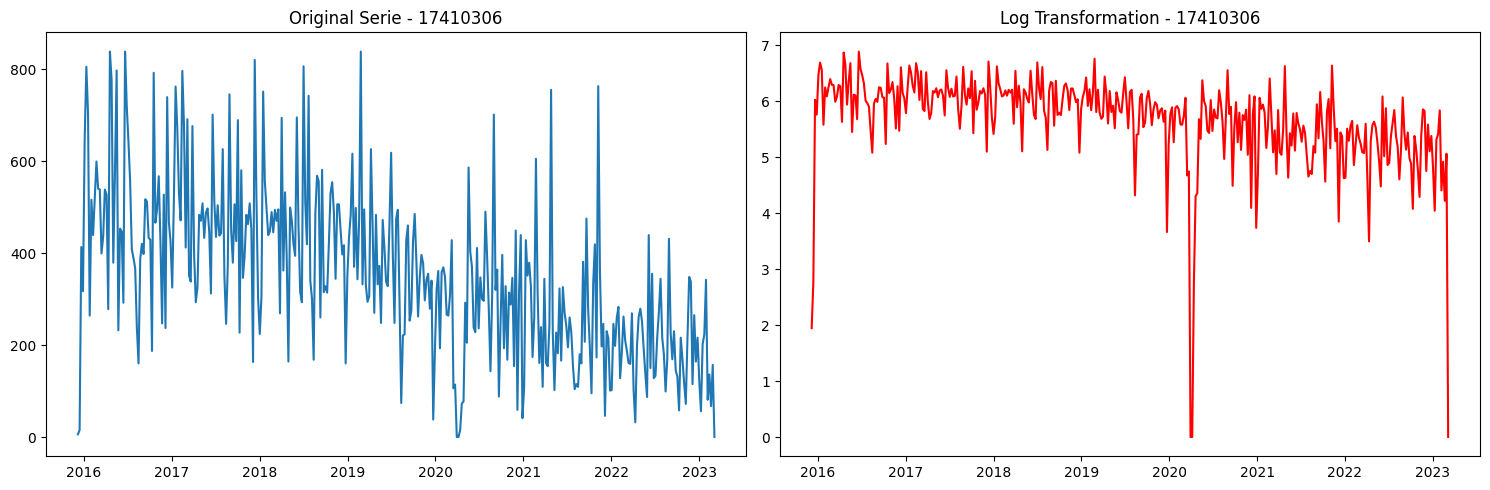

13:24:17 - cmdstanpy - INFO - Chain [1] start processing
13:24:17 - cmdstanpy - INFO - Chain [1] done processing
13:24:31 - cmdstanpy - INFO - Chain [1] start processing
13:24:31 - cmdstanpy - INFO - Chain [1] done processing
13:24:41 - cmdstanpy - INFO - Chain [1] start processing
13:24:41 - cmdstanpy - INFO - Chain [1] done processing
13:24:50 - cmdstanpy - INFO - Chain [1] start processing
13:24:50 - cmdstanpy - INFO - Chain [1] done processing
13:25:01 - cmdstanpy - INFO - Chain [1] start processing
13:25:01 - cmdstanpy - INFO - Chain [1] done processing
13:25:10 - cmdstanpy - INFO - Chain [1] start processing
13:25:11 - cmdstanpy - INFO - Chain [1] done processing
13:25:20 - cmdstanpy - INFO - Chain [1] start processing
13:25:20 - cmdstanpy - INFO - Chain [1] done processing
13:25:31 - cmdstanpy - INFO - Chain [1] start processing
13:25:34 - cmdstanpy - INFO - Chain [1] done processing
13:25:43 - cmdstanpy - INFO - Chain [1] start processing
13:25:43 - cmdstanpy - INFO - Chain [1]

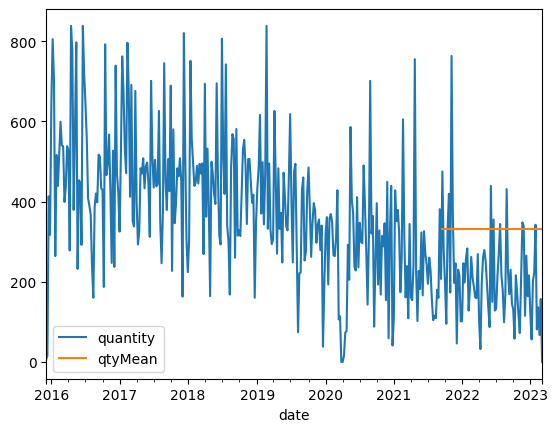

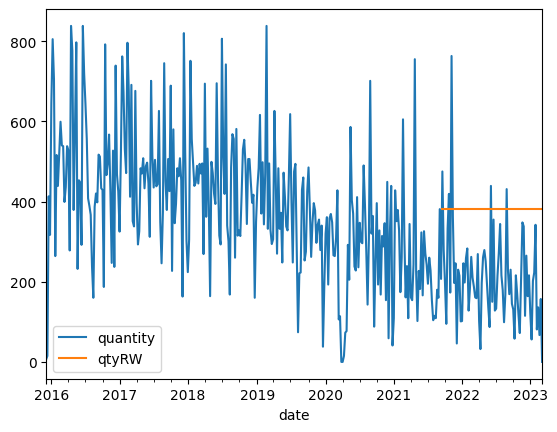

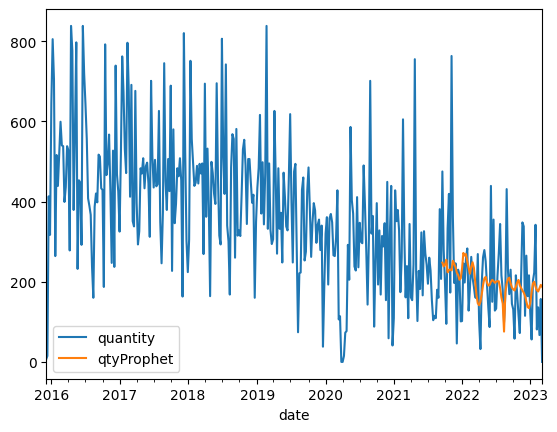

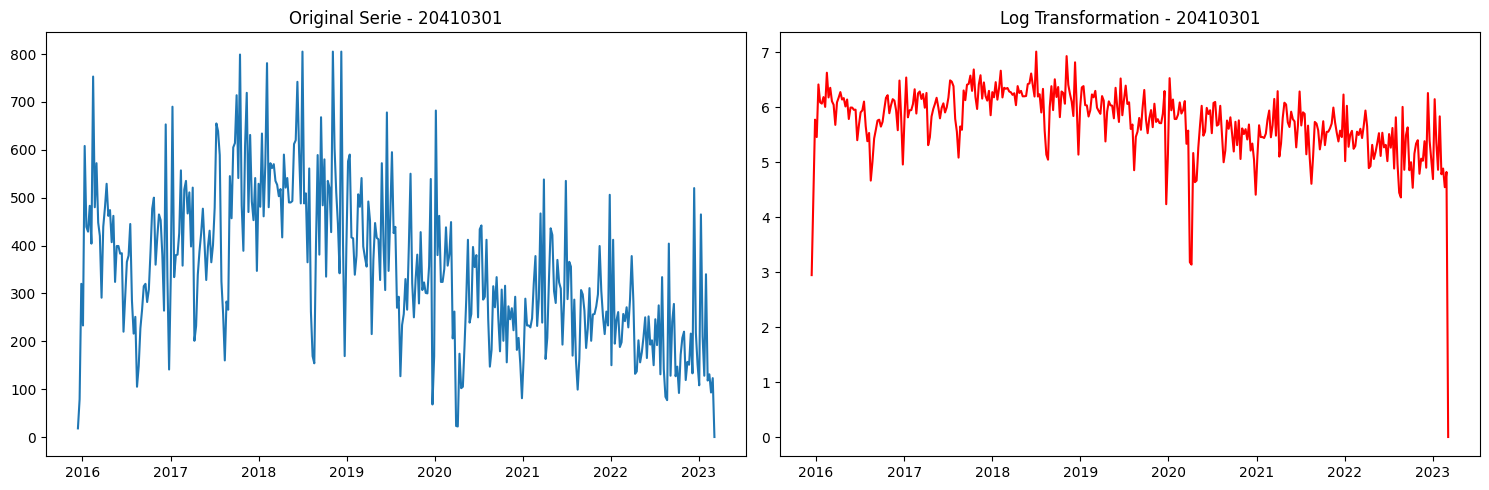

13:29:30 - cmdstanpy - INFO - Chain [1] start processing
13:29:30 - cmdstanpy - INFO - Chain [1] done processing
13:29:42 - cmdstanpy - INFO - Chain [1] start processing
13:29:42 - cmdstanpy - INFO - Chain [1] done processing
13:29:53 - cmdstanpy - INFO - Chain [1] start processing
13:29:53 - cmdstanpy - INFO - Chain [1] done processing
13:30:03 - cmdstanpy - INFO - Chain [1] start processing
13:30:03 - cmdstanpy - INFO - Chain [1] done processing
13:30:12 - cmdstanpy - INFO - Chain [1] start processing
13:30:12 - cmdstanpy - INFO - Chain [1] done processing
13:30:21 - cmdstanpy - INFO - Chain [1] start processing
13:30:21 - cmdstanpy - INFO - Chain [1] done processing
13:30:30 - cmdstanpy - INFO - Chain [1] start processing
13:30:30 - cmdstanpy - INFO - Chain [1] done processing
13:30:40 - cmdstanpy - INFO - Chain [1] start processing
13:30:40 - cmdstanpy - INFO - Chain [1] done processing
13:30:50 - cmdstanpy - INFO - Chain [1] start processing
13:30:50 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

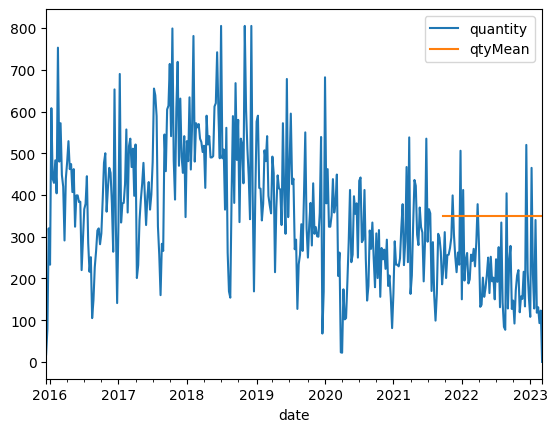

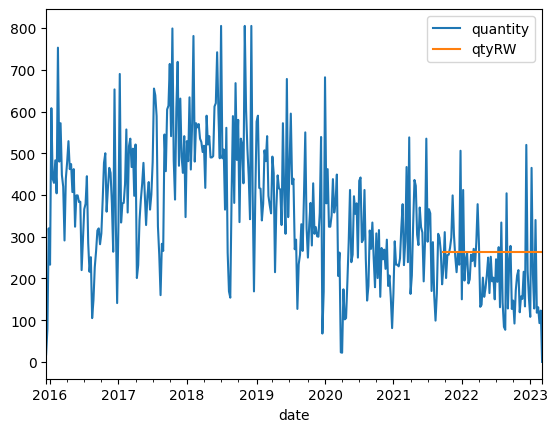

In [120]:
for item in id_list:
    one_product = sales[sales['id']==item]
    one_product = one_product.drop_duplicates()
    one_product = replace_outliers(one_product)
    ts_plot = initial_plots(one_product, item)
    split_date, train, test = split(one_product)
    one_product, test = apply_mean_model(one_product, train, test, item)
    one_product, train, test = apply_linear_model(one_product, train, test, item)
    one_product, train, test = apply_random_walk(one_product, train, test, item)
    one_product, train, test = apply_moving_average(one_product, train, test, item)
    #one_product, test = apply_arima(one_product, train, test, item)
    prophet_product, best_params = tuning_hyperparameters_prophet(one_product, train, test, item, split_date)
    one_product, test = apply_prophet(one_product, prophet_product, best_params, train, test, item, split_date)


Include complementary info about products

In [121]:
metrics = metrics.merge(products_info[['id','num_records', 'percentage_zero','n_zero', 'n_wk_consecutive']], how='left', on='id')
metrics

,id,model,rmse,mape,mase,num_records,percentage_zero,n_zero,n_wk_consecutive
0,17410306,mean,169.342281,1.931682e+16,0.851436,379,0.007916,3,376
1,17410306,Linear model,116.331459,9.676737e+15,0.469554,379,0.007916,3,376
2,17410306,Random Walk,208.903165,2.228404e+16,1.089390,379,0.007916,3,376
3,17410306,Moving average,117.769090,1.277152e+16,0.495369,379,0.007916,3,376
4,17410306,mean,169.342281,1.931682e+16,0.841863,379,0.007916,3,376
5,17410306,Linear model,116.331459,9.676737e+15,0.464275,379,0.007916,3,376
6,17410306,Random Walk,208.903165,2.228404e+16,1.077142,379,0.007916,3,376
7,17410306,Moving average,117.769090,1.277152e+16,0.489800,379,0.007916,3,376
8,17410306,mean,169.342281,1.931682e+16,0.851436,379,0.007916,3,376
9,17410306,Linear model,116.331459,9.676737e+15,0.469554,379,0.007916,3,376


In [ ]:
id_ex = '17410306'
m = sales[sales['id']== id_ex]

In [117]:
prof_data, params = tuning_hyperparameters_prophet(one_product, train, test, item, split_date)

13:21:59 - cmdstanpy - INFO - Chain [1] start processing
13:21:59 - cmdstanpy - INFO - Chain [1] done processing
13:22:09 - cmdstanpy - INFO - Chain [1] start processing
13:22:09 - cmdstanpy - INFO - Chain [1] done processing
13:22:19 - cmdstanpy - INFO - Chain [1] start processing
13:22:19 - cmdstanpy - INFO - Chain [1] done processing
13:22:31 - cmdstanpy - INFO - Chain [1] start processing
13:22:31 - cmdstanpy - INFO - Chain [1] done processing
13:22:40 - cmdstanpy - INFO - Chain [1] start processing
13:22:40 - cmdstanpy - INFO - Chain [1] done processing
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] done processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

In [ ]:
new_df = pd.DataFrame({'ds': one_product.index.to_timestamp(),'y':one_product.log}).reset_index()
new_df = new_df.drop('date', axis=1)
new_df

In [110]:
new_df.ds

0     2015-12-07
1     2015-12-14
2     2015-12-21
3     2015-12-28
4     2016-01-04
         ...    
374   2023-02-06
375   2023-02-13
376   2023-02-20
377   2023-02-27
378   2023-03-06
Name: ds, Length: 379, dtype: datetime64[ns]